<a href="https://colab.research.google.com/github/sabyasachi-mohanty/AIML/blob/master/attend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 2.7 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

#import os
#print(os.listdir("/content/drive/MyDrive/PHOTOS_DivineAI"))

In [5]:
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    print(results)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array
       

# load the photo and extract the face
#pixels = extract_face('/content/drive/MyDrive/PHOTOS_DivineAI/train/Arpan Kumar Tripathy - KIIT - B.Tech(3)/Image 1.jpg')
#plt.imshow(pixels)
#plt.show()
#print(pixels.shape)

In [7]:
import numpy as np
data = np.load('/content/drive/MyDrive/AIML/faces-dataset-copy1.npz', allow_pickle=True)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (591, 160, 160, 3) (591,) (72, 160, 160, 3) (72,)


In [8]:
facenet_model = load_model('/content/drive/MyDrive/AIML/facenet_keras.h5',compile = False)
print('Loaded Model')

Loaded Model


In [9]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
  if face!= 'None':
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
      
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


(591, 128)
(72, 128)


In [10]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=591, test=72
Accuracy: train=96.616, test=95.833


In [16]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


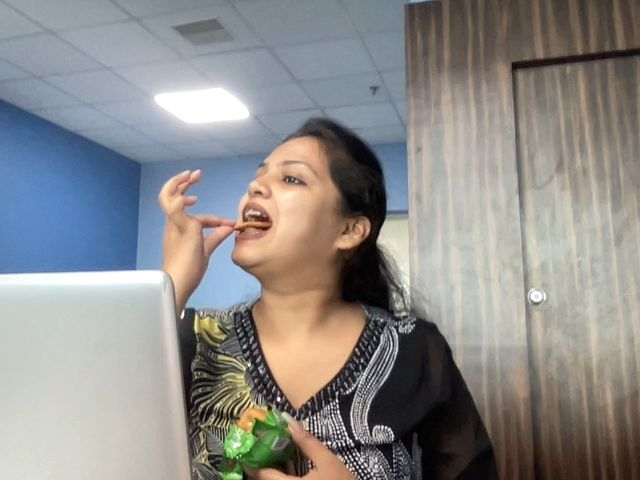

In [15]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [19]:
import datetime
from datetime import date,timedelta
def markAttendance(name):
    with open('/content/drive/MyDrive/AIML/attendence.csv', 'r+') as f:
        myDataList = f.readlines()

        nameList = []
        for line in myDataList:
            entry = line.split(',')
            nameList.append(entry[0])
        if name not in nameList:
            now = datetime.datetime.utcnow()+datetime.timedelta(hours=5)+datetime.timedelta(minutes=30)
            print(now)
            dtString = now.strftime("%d/%m/%Y %H:%M:%S")
            f.writelines(f'\n{name},{dtString}')


[{'box': [235, 133, 95, 130], 'confidence': 0.9998407363891602, 'keypoints': {'left_eye': (257, 177), 'right_eye': (292, 179), 'nose': (250, 186), 'mouth_left': (241, 222), 'mouth_right': (267, 224)}}]
Predicted: 
['AMIYA PALAI' 'ANKIT KUMAR BHUYAN' 'ARYAN SHAY' 'ASISH TRIPATHY'
 'Arpan Kumar Tripathy - KIIT - B.Tech(3)'] 
[4.61347379e-10 3.87540561e-10 3.81095877e-10 4.61963772e-10
 3.47048366e-10 7.99127260e-09 5.51434309e-10 5.86374088e-10
 9.99999303e+01 4.01692742e-07 3.13944363e-07 3.18240690e-07
 4.62763701e-07 3.06346066e-07 1.45854805e-06 3.88257859e-07
 3.66298059e-07 1.59558008e-06 1.18539005e-06 6.22802760e-07
 7.47959196e-07 2.28702782e-06 7.86605281e-07 2.84800051e-07
 8.18817233e-07 1.46798240e-06 3.43433961e-06 3.49895232e-07
 3.05562029e-05 5.48344169e-07 6.20999531e-07 1.06237359e-06
 1.64580745e-05 6.80159037e-07 3.16564573e-07 9.27212704e-07
 9.13711585e-07]
2021-10-05 13:39:35.598967


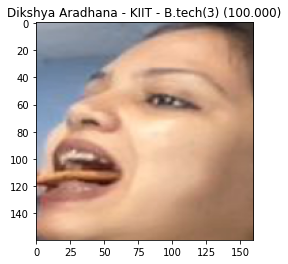

In [20]:
#from random import choice
from numpy import asarray
from PIL import Image
# select a random face from test set
random_face = extract_face('/content/photo.jpg')
random_face_emd = get_embedding(facenet_model,random_face)
# random_face_class = testy_enc[selection]
# random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
#print('Expected: %s' % random_face_name[0])
# plot face
if(class_probability>50):
  markAttendance(predict_names[0])
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()